In [27]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from matplotlib import pyplot as plt

In [26]:
device = "cpu"

In [5]:
df = pd.read_csv('/data/data.csv', sep=";")
df.head()

,Player1,Player2,Player3,Player4,Eichel Ober,Eichel Unter,Eichel Ass,Eichel 10,Eichel König,Eichel 9,...,SchellenOber,SchellenUnter,SchellenAss,Schellen10,SchellenKönig,Schellen9,Schellen8,Schellen7,Modus,Win
0,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,1,1,0,0,weiter,-1
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,weiter,-1
2,0,0,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,Farbwenz Schelle,1
3,0,0,0,1,1,0,0,0,0,0,...,1,1,0,0,0,0,0,1,Farbgeier Schelle,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,1,weiter,1


In [6]:
df_weiter = df[df['Modus'] == 'weiter']
df_play = df[df['Modus'] != 'weiter']

min_samples = min(len(df_weiter), len(df_play))

df_weiter_sampled = df_weiter.sample(min_samples, random_state=42)
df_play_sampled = df_play.sample(min_samples, random_state=42)


df_balanced = pd.concat([df_weiter_sampled, df_play_sampled])


In [7]:
train_data = df_balanced.drop(['Player1','Player2','Player3','Player4','Win','Modus'], axis=1).astype("float32")
train_data.head()

,Eichel Ober,Eichel Unter,Eichel Ass,Eichel 10,Eichel König,Eichel 9,Eichel 8,Eichel 7,Gras Ober,Gras Unter,...,Herz 8,Herz 7,SchellenOber,SchellenUnter,SchellenAss,Schellen10,SchellenKönig,Schellen9,Schellen8,Schellen7
15175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
73084,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2003,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
129838,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40394,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train_data_size = np.shape(np.array(train_data))
input_size = train_data_size[1]
output_size = 2
print("Input Size: ", input_size)

Input Size:  32


In [9]:
filter_weiter = lambda mode: 0 if mode == "weiter" else 1
y = df_balanced['Modus'].apply(filter_weiter)
y.head()

15175     0
73084     0
2003      0
129838    0
40394     0
Name: Modus, dtype: int64

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y, test_size=0.2, random_state=42)
y_train.head()

50787     1
92251     0
96218     1
99093     1
155457    0
Name: Modus, dtype: int64

In [11]:
print(len(y_train[y_train == 0]))

31719


In [12]:
class SelectGameDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor([self.X.iloc[idx]], device=device), torch.tensor(self.y.iloc[idx], device=device)

In [13]:
train_dataset = SelectGameDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [14]:
test_dataset = SelectGameDataset(X_val, y_val)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
class ShouldPlayNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [16]:
model = ShouldPlayNN().to(device)
print(model)

ShouldPlayNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [17]:
num_epochs = 100
print_freq = 500  

for epoch in range(num_epochs):
    running_loss = 0.0  
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()
        
        running_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {running_loss / print_freq:.4f}")
            running_loss = 0.0  

Epoch [1/100] Batch [500/990] Loss: 0.3957
Epoch [2/100] Batch [500/990] Loss: 0.3063
Epoch [3/100] Batch [500/990] Loss: 0.2863
Epoch [4/100] Batch [500/990] Loss: 0.2823
Epoch [5/100] Batch [500/990] Loss: 0.2778
Epoch [6/100] Batch [500/990] Loss: 0.2747
Epoch [7/100] Batch [500/990] Loss: 0.2743
Epoch [8/100] Batch [500/990] Loss: 0.2679
Epoch [9/100] Batch [500/990] Loss: 0.2665
Epoch [10/100] Batch [500/990] Loss: 0.2711
Epoch [11/100] Batch [500/990] Loss: 0.2671
Epoch [12/100] Batch [500/990] Loss: 0.2613
Epoch [13/100] Batch [500/990] Loss: 0.2660
Epoch [14/100] Batch [500/990] Loss: 0.2598
Epoch [15/100] Batch [500/990] Loss: 0.2626
Epoch [16/100] Batch [500/990] Loss: 0.2578
Epoch [17/100] Batch [500/990] Loss: 0.2584
Epoch [18/100] Batch [500/990] Loss: 0.2590
Epoch [19/100] Batch [500/990] Loss: 0.2574
Epoch [20/100] Batch [500/990] Loss: 0.2528
Epoch [21/100] Batch [500/990] Loss: 0.2546
Epoch [22/100] Batch [500/990] Loss: 0.2524
Epoch [23/100] Batch [500/990] Loss: 0.25

In [11]:

torch.save(model.state_dict(), 'binary_classifier.pth')

In [17]:
model_params_path = '/Users/joshua.stalla/Desktop/Studium/GamesEngineering/schafkopf-server/src/ai/select_game_type/two_layer_nn/models/binary_classifier.pth'
#os.path.join(os.getcwd(), "model", "params.pth")
params = torch.load(model_params_path, map_location=torch.device(device))
model = ShouldPlayNN()
model.load_state_dict(params)

<All keys matched successfully>

In [18]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# TODO: Evaluate for seperate classes

model.train()

Test Accuracy: 86.31%


ShouldPlayNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [19]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

In [23]:
category_mapping = ['weiter', 'play']

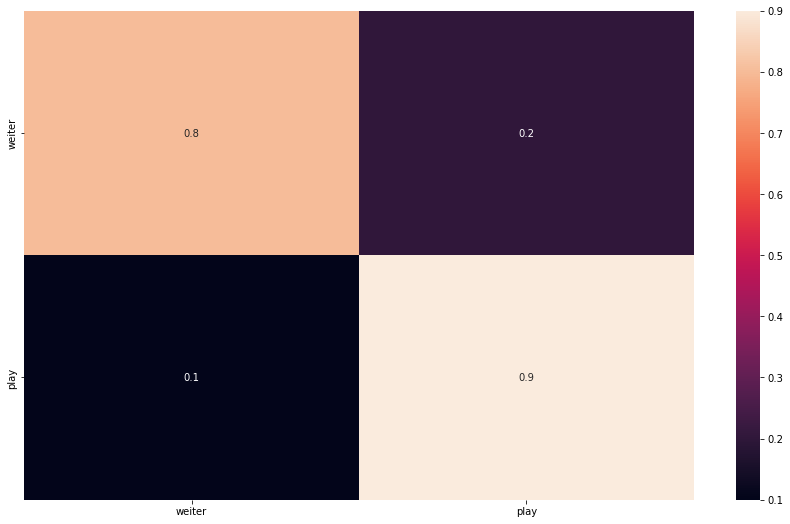

In [28]:
# your previous confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cf_matrix_norm = cf_matrix / np.sum(cf_matrix, axis=1)[:, np.newaxis]
cf_matrix_norm_rounded = np.round(cf_matrix_norm, decimals=1)  # round to 1 decimal

# Create DataFrame from the normalized and rounded confusion matrix
df_cm = pd.DataFrame(cf_matrix_norm_rounded, index=[i for i in category_mapping],
                     columns=[i for i in category_mapping])

# Create the heatmap with seaborn
plt.figure(figsize=(15, 9))
sn.heatmap(df_cm, annot=True, fmt='.1f')  # specify decimal format here for the annotation
plt.show()